# Preprocessing and image conversion

In [ ]:
import numpy as np
import subprocess
import random
import progressbar
from glob import glob
from skimage import io

In [2]:
np.random.seed(5) # for reproducibility
progress = progressbar.ProgressBar(widgets=[progressbar.Bar('*', '[', ']'), progressbar.Percentage(), ' '])

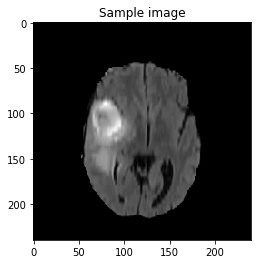

In [5]:
img=io.imread("/Users/barrm/Documents/NYU/Image & Video Processing/project/BRATS_2015/Training/HGG/brats_2013_pat0001_1/VSD.Brain.XX.O.MR_Flair.54512/VSD.Brain.XX.O.MR_Flair.54512.mha", plugin='simpleitk').astype(float)

plt.imshow(img[70,:,:], cmap='gray')
plt.title("Sample image")
plt.show()

In [66]:
class BrainPipeline(object):
    '''
    A class for processing brain scans for one patient
    INPUT:  (1) filepath 'path': path to directory of one patient. Contains following mha files:
            flair, t1, t1c, t2, ground truth (gt)
            (2) bool 'n4itk': True to use n4itk normed t1 scans (defaults to True)
            (3) bool 'n4itk_apply': True to apply and save n4itk filter to t1 and t1c scans for given patient. This will only work if the
    '''
    def __init__(self, path, n4itk = True, n4itk_apply = False):
        self.path = path
        self.n4itk = n4itk
        self.n4itk_apply = n4itk_apply
        self.modes = ['flair', 't1', 't1c', 't2', 'gt']
        # slices=[[flair x 155], [t1], [t1c], [t2], [gt]], 155 per modality
        self.slices_by_mode, n = self.read_scans()
        # [ [slice1 x 5], [slice2 x 5], ..., [slice155 x 5]]
        self.slices_by_slice = n
        self.normed_slices = self.norm_slices()

    def read_scans(self):
        '''
        goes into each modality in patient directory and loads individual scans.
        transforms scans of same slice into strip of 5 images
        '''
        print ('Loading scans...')
        slices_by_mode = np.zeros((5, 155, 240, 240))
        slices_by_slice = np.zeros((155, 5, 240, 240))
        flair = glob(self.path + '/*Flair*/*.mha')
        t2 = glob(self.path + '/*_T2*/*.mha')
        gt = glob(self.path + '/*more*/*.mha')
        t1s = glob(self.path + '/*T1*/*.mha')
        t1_n4 = glob(self.path + '/*T1c*/*.mha')  # <-----  CAHNGE TO t1c
        t1 = [scan for scan in t1s if scan not in t1_n4]

        #scans = [flair[0], t1[0], t1[1], t2[0], gt[0]] # directories to each image (5 total)
        #if self.n4itk_apply:
        #    print ('-> Applyling bias correction...')
        #    for t1_path in t1:
        #        self.n4itk_norm(t1_path) # normalize files
        #    scans = [flair[0], t1_n4[0], t1_n4[1], t2[0], gt[0]]
        #elif self.n4itk:
        scans = [flair[0], t1_n4[0], t1_n4[0], t2[0], gt[0]]
        for scan_idx in range(5):
            # read each image directory, save to self.slices
            slices_by_mode[scan_idx] = io.imread(scans[scan_idx], plugin='simpleitk').astype(float)
        for mode_ix in range(slices_by_mode.shape[0]): # modes 1 thru 5
            for slice_ix in range(slices_by_mode.shape[1]): # slices 1 thru 155
                slices_by_slice[slice_ix][mode_ix] = slices_by_mode[mode_ix][slice_ix] # reshape by slice
        return slices_by_mode, slices_by_slice
    
    def norm_slices(self):
        '''
        normalizes each slice in self.slices_by_slice, excluding gt
        subtracts mean and div by std dev for each slice
        clips top and bottom one percent of pixel intensities
        if n4itk == True, will apply n4itk bias correction to T1 and T1c images
            '''

        print('Normalizing slices...')
        normed_slices = np.zeros((155, 5, 240, 240))
        for slice_ix in range(155):
            normed_slices[slice_ix][-1] = self.slices_by_slice[slice_ix][-1]
            for mode_ix in range(4):
                normed_slices[slice_ix][mode_ix] =  self._normalize(self.slices_by_slice[slice_ix][mode_ix])
        print('Done')
        return normed_slices

    def _normalize(self, slice):
        '''
        INPUT:  (1) a single slice of any given modality (excluding gt)
                (2) index of modality assoc with slice (0=flair, 1=t1, 2=t1c, 3=t2)
        OUTPUT: normalized slice
         '''
        b, t = np.percentile(slice, (0.5,99.5))
        slice = np.clip(slice, b, t)
        if np.std(slice) == 0:
            return slice
        else:
            return (slice - np.mean(slice)) / np.std(slice)
        
    def save_patient(self, reg_norm_n4, patient_num):
        '''
        INPUT:  (1) int 'patient_num': unique identifier for each patient
                (2) string 'reg_norm_n4': 'reg' for original images, 'norm' normalized images, 'n4' for n4 normalized images
        OUTPUT: saves png in Norm_PNG directory for normed, Training_PNG for reg
        '''
        print ('Saving scans for patient {}...'.format(patient_num))
        progress.currval = 0
        if reg_norm_n4 == 'norm': #saved normed slices
            for slice_ix in range(155): # reshape to strip
                strip = self.normed_slices[slice_ix].reshape(1200, 240)
                if np.max(strip) != 0: # set values < 1
                    strip /= np.max(strip)
                if np.min(strip) <= -1: # set values > -1
                    strip /= abs(np.min(strip))
                # save as patient_slice.png
                io.imsave('Norm_PNG/{}_{}.png'.format(patient_num, slice_ix), strip)
        elif reg_norm_n4 == 'reg':
            for slice_ix in range(155):
                strip = self.slices_by_slice[slice_ix].reshape(1200, 240)
                if np.max(strip) != 0:
                    strip /= np.max(strip)
                io.imsave('Training_PNG/{}_{}.png'.format(patient_num, slice_ix), strip)
        else:
            for slice_ix in range(155): # reshape to strip
                strip = self.normed_slices[slice_ix].reshape(1200, 240)
                if np.max(strip) != 0: # set values < 1
                    strip /= np.max(strip)
                if np.min(strip) <= -1: # set values > -1
                    strip /= abs(np.min(strip))
                # save as patient_slice.png
                io.imsave('n4_PNG/{}_{}.png'.format(patient_num, slice_ix), strip)
    
    

In [67]:
#bias correc?

In [68]:
def save_patient_slices(patients, type):
    '''
    INPUT   (1) list 'patients': paths to any directories of patients to save. for example- glob("Training/HGG/**")
            (2) string 'type': options = reg (non-normalized), norm (normalized, but no bias correction), n4 (bias corrected and normalized)
    saves strips of patient slices to approriate directory (Training_PNG/, Norm_PNG/ or n4_PNG/) as patient-num_slice-num
    '''
    for patient_num, path in enumerate(patients):
        a = BrainPipeline(path)
        a.save_patient(type, patient_num)

In [69]:
def save_labels(fns):
    '''
    INPUT list 'fns': filepaths to all labels
    '''
    progress.currval = 0
    for label_idx in range(len(labels)):
        slices = io.imread(labels[label_idx], plugin = 'simpleitk')
        for slice_idx in range(len(slices)):
            io.imsave('Labels/{}_{}L.png'.format(label_idx, slice_idx), slices[slice_idx])

In [ ]:
if __name__ == '__main__':
    #labels = glob('BRATS_2015/Training/HGG/**/*more*/*.mha')
    #save_labels(labels)
    patients = glob('BRATS_2015/Training/HGG/**')
    #save_patient_slices(patients, 'reg')
    save_patient_slices(patients, 'norm')
    #save_patient_slices(patients, 'n4')

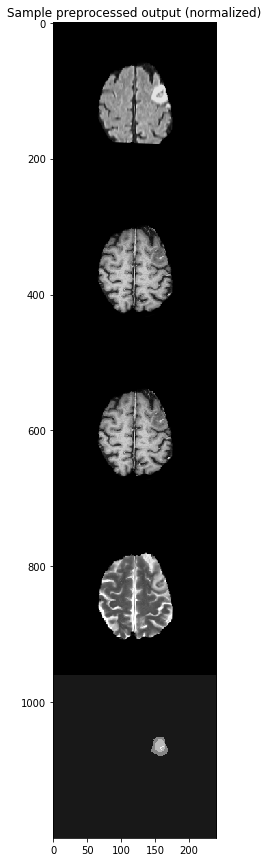

In [20]:
img=io.imread("/Users/barrm/Documents/NYU/Image & Video Processing/project/Norm_PNG/5_117.png")

plt.figure(figsize = (5,15))
plt.imshow(img, cmap='gray')
plt.title("Sample preprocessed output (normalized)")
plt.show()